# BMW Sales Classification: EDA, Visualization, and Modeling

This notebook performs EDA, preprocessing, visualization, a logistic-regression baseline, and a PyTorch tabular MLP for the binary target `Sales_Classification` (High vs Low) using the provided CSV with ~10 features.

Sections include: data checks, 5+ visuals, stratified splits, model training, and held-out test evaluation with confusion matrix and ROC–AUC.

In [1]:
# Environment and imports
import os, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", context="notebook")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support, roc_auc_score,
                             confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report)
from sklearn.linear_model import LogisticRegression

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# CSV path
DATA_PATH = "/content/BMW sales data (2010-2024) (1).csv"
assert os.path.exists(DATA_PATH), f"CSV not found at {DATA_PATH}. Place it next to this notebook."

## Load data and quick look
Preview shape, dtypes, missing values, and duplicates to plan preprocessing and sanity-check the target column presence.

In [2]:
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head(10))
print("\nDtypes:\n", df.dtypes)
print("\nMissing values per column:\n", df.isna().sum())
dup_count = df.duplicated().sum()
print(f"\nDuplicate rows: {dup_count}")

Shape: (50000, 11)


,Model,Year,Region,Color,Fuel_Type,Transmission,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Sales_Classification
0,5 Series,2016,Asia,Red,Petrol,Manual,3.5,151748,98740,8300,High
1,i8,2013,North America,Red,Hybrid,Automatic,1.6,121671,79219,3428,Low
2,5 Series,2022,North America,Blue,Petrol,Automatic,4.5,10991,113265,6994,Low
3,X3,2024,Middle East,Blue,Petrol,Automatic,1.7,27255,60971,4047,Low
4,7 Series,2020,South America,Black,Diesel,Manual,2.1,122131,49898,3080,Low
5,5 Series,2017,Middle East,Silver,Diesel,Manual,1.9,171362,42926,1232,Low
6,i8,2022,Europe,White,Diesel,Manual,1.8,196741,55064,7949,High
7,M5,2014,Asia,Black,Diesel,Automatic,1.6,121156,102778,632,Low
8,X3,2016,South America,White,Diesel,Automatic,1.7,48073,116482,8944,High
9,i8,2019,Europe,White,Electric,Manual,3.0,35700,96257,4411,Low



Dtypes:
 Model                    object
Year                      int64
Region                   object
Color                    object
Fuel_Type                object
Transmission             object
Engine_Size_L           float64
Mileage_KM                int64
Price_USD                 int64
Sales_Volume              int64
Sales_Classification     object
dtype: object

Missing values per column:
 Model                   0
Year                    0
Region                  0
Color                   0
Fuel_Type               0
Transmission            0
Engine_Size_L           0
Mileage_KM              0
Price_USD               0
Sales_Volume            0
Sales_Classification    0
dtype: int64

Duplicate rows: 0


## Target checks and class balance
Confirm `Sales_Classification` exists, verify binary classes High/Low, and inspect balance to inform weighting/thresholds.

In [3]:
TARGET_COL = "Sales_Classification"
assert TARGET_COL in df.columns, f"Target column '{TARGET_COL}' not found."
print("Target value counts:\n", df[TARGET_COL].value_counts(dropna=False))
print("Target unique values:", df[TARGET_COL].astype(str).unique())

Target value counts:
 Sales_Classification
Low     34754
High    15246
Name: count, dtype: int64
Target unique values: ['High' 'Low']


## EDA: numeric distributions and outliers
Plot histograms and boxplots for numeric features to understand scale, skew, and potential outliers.

Numeric columns: ['Year', 'Engine_Size_L', 'Mileage_KM', 'Price_USD', 'Sales_Volume']
Categorical columns: ['Model', 'Region', 'Color', 'Fuel_Type', 'Transmission']


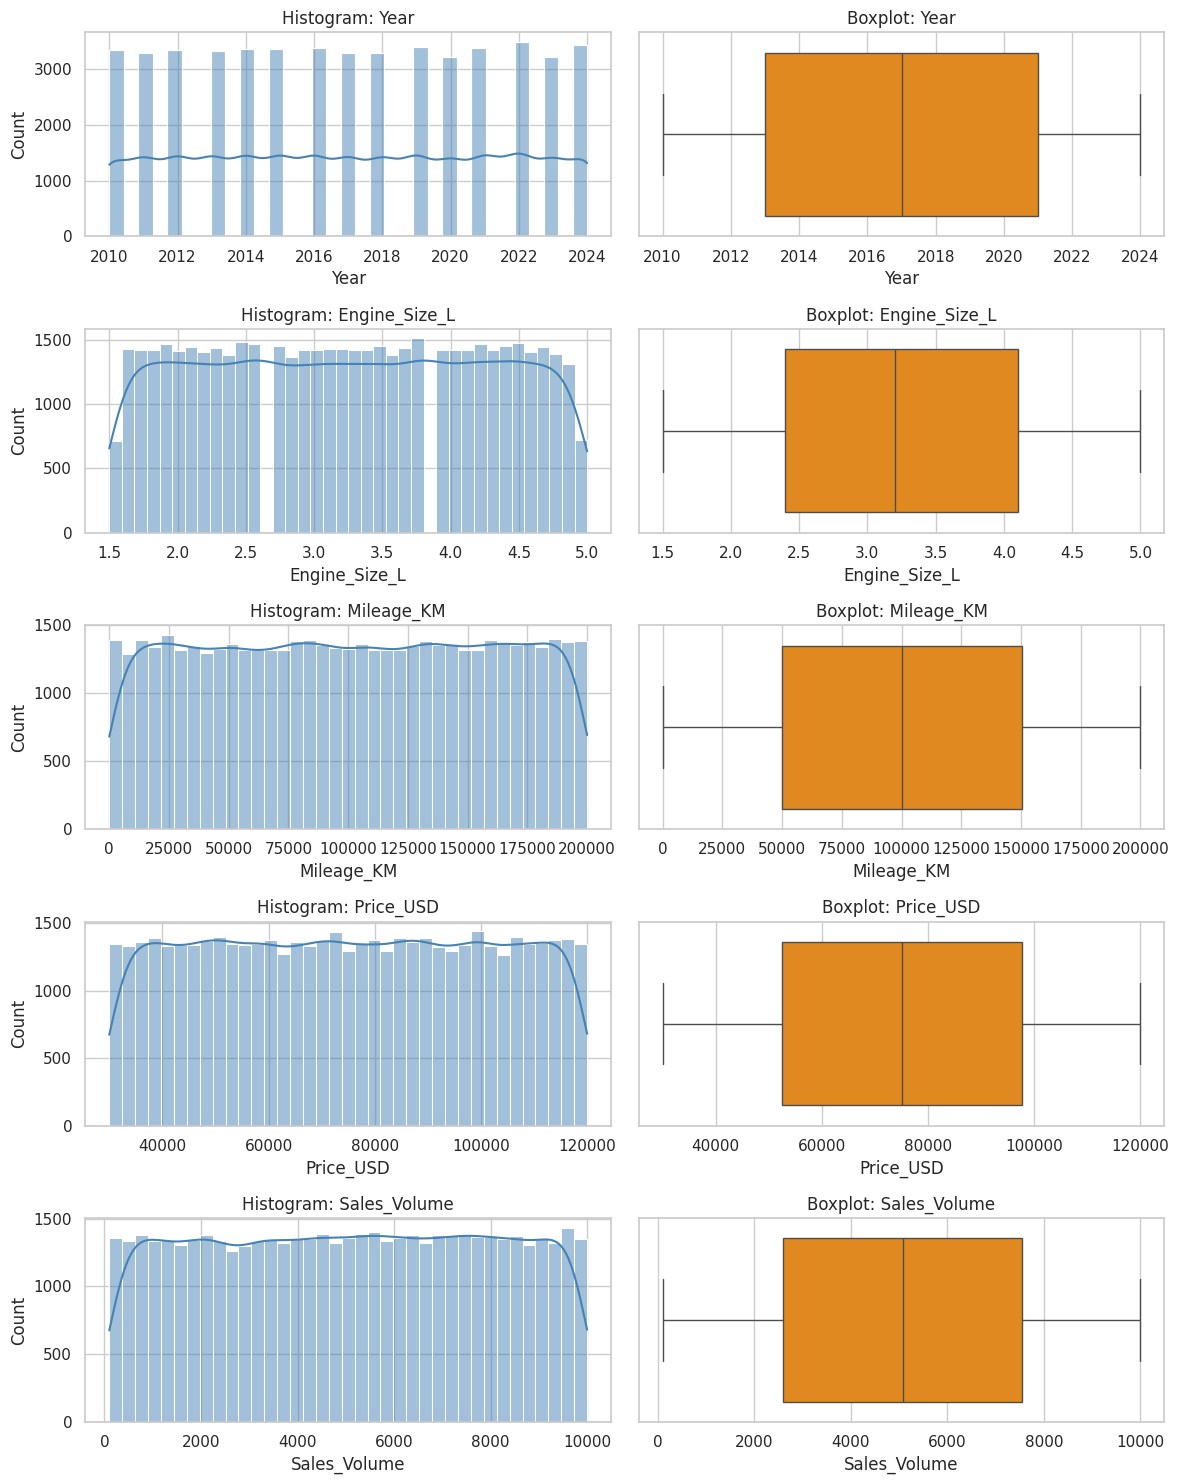

In [4]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in df.columns if c not in numeric_cols + [TARGET_COL]]
print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

num_to_plot = numeric_cols[:6]  # keep visuals readable
fig, axes = plt.subplots(len(num_to_plot), 2, figsize=(12, max(3*len(num_to_plot), 6)))
for i, col in enumerate(num_to_plot):
    sns.histplot(df[col], kde=True, ax=axes[i,0], color='steelblue')
    axes[i,0].set_title(f"Histogram: {col}")
    sns.boxplot(x=df[col], ax=axes[i,1], color='darkorange')
    axes[i,1].set_title(f"Boxplot: {col}")
plt.tight_layout(); plt.show()

## EDA: correlations and pairwise patterns
Visualize a correlation heatmap for numeric features and a small pairplot sample stratified by the target.

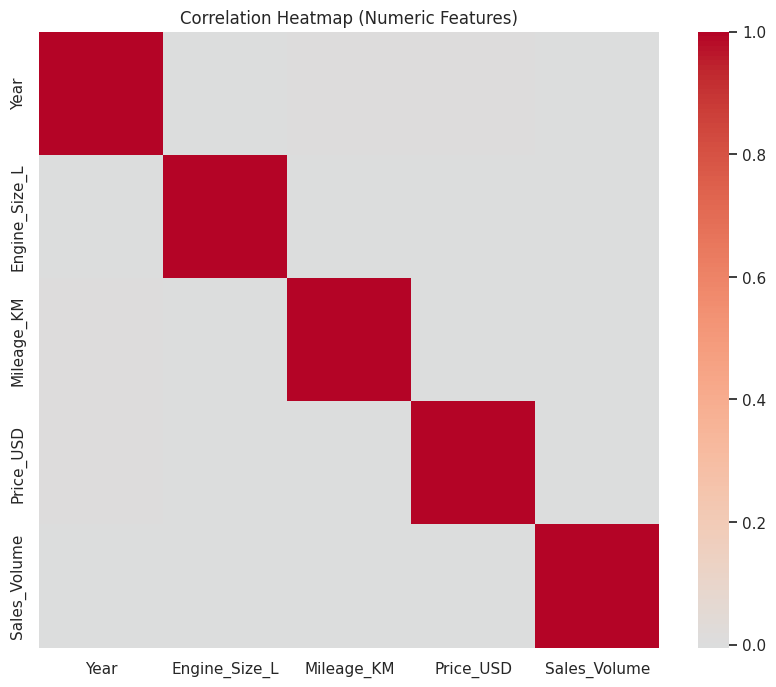

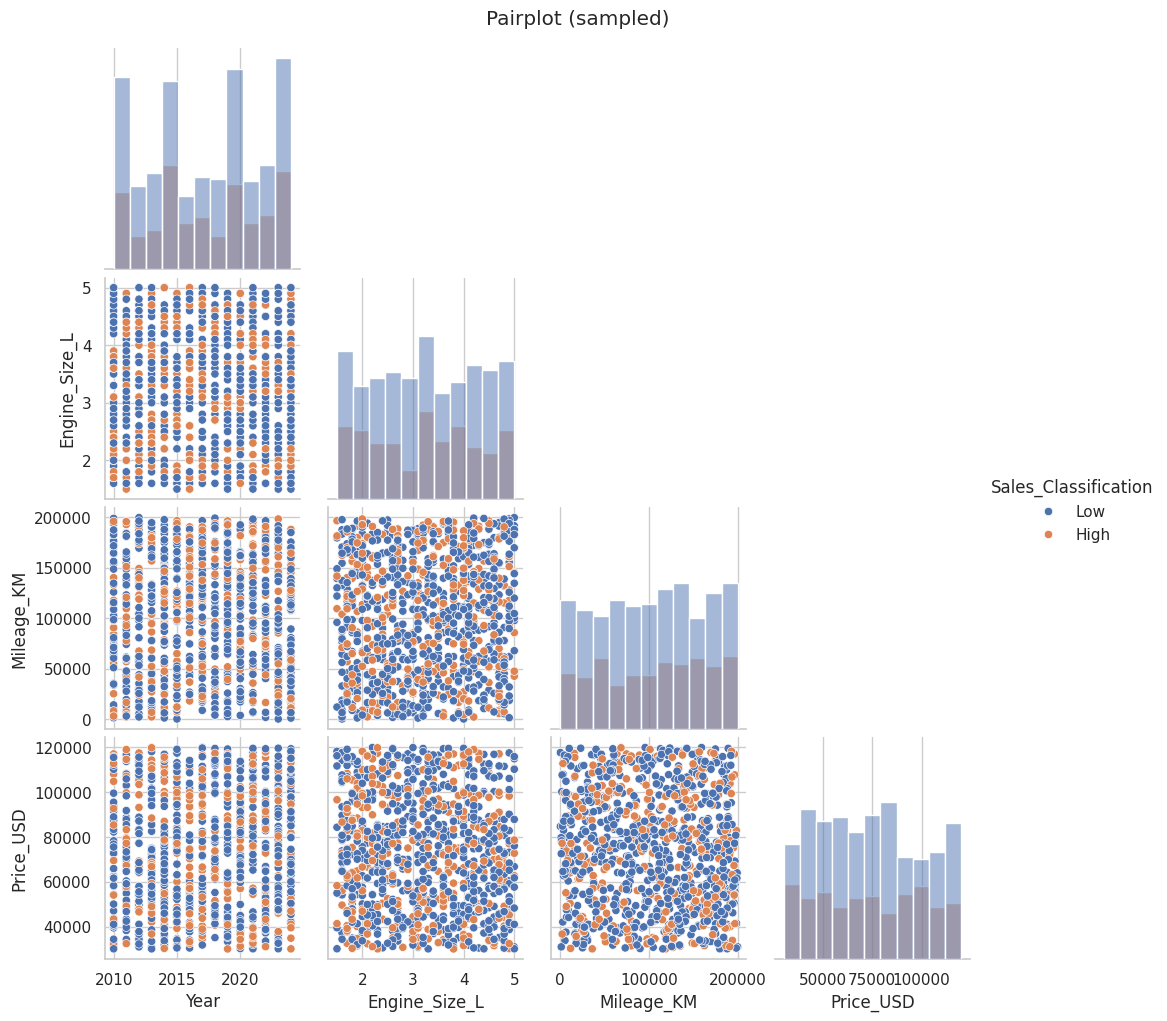

In [5]:
if len(numeric_cols) >= 2:
    corr = df[numeric_cols].corr(numeric_only=True)
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
    plt.title("Correlation Heatmap (Numeric Features)")
    plt.show()

pp_cols = numeric_cols[:4]
if len(pp_cols) >= 2:
    sample_df = df[[*pp_cols, TARGET_COL]].copy()
    sample_df[TARGET_COL] = sample_df[TARGET_COL].astype(str)
    sample_small = sample_df.sample(n=min(1000, len(sample_df)), random_state=RANDOM_STATE)
    sns.pairplot(sample_small, vars=pp_cols, hue=TARGET_COL, diag_kind='hist', corner=True)
    plt.suptitle("Pairplot (sampled)", y=1.02)
    plt.show()

## EDA: categorical distributions vs target
Count plots per category level with target hue reveal dominant levels and potential separability or leakage.

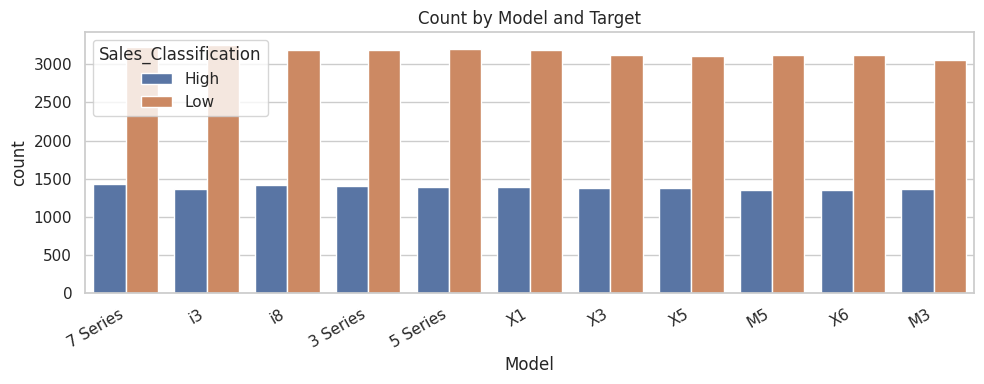

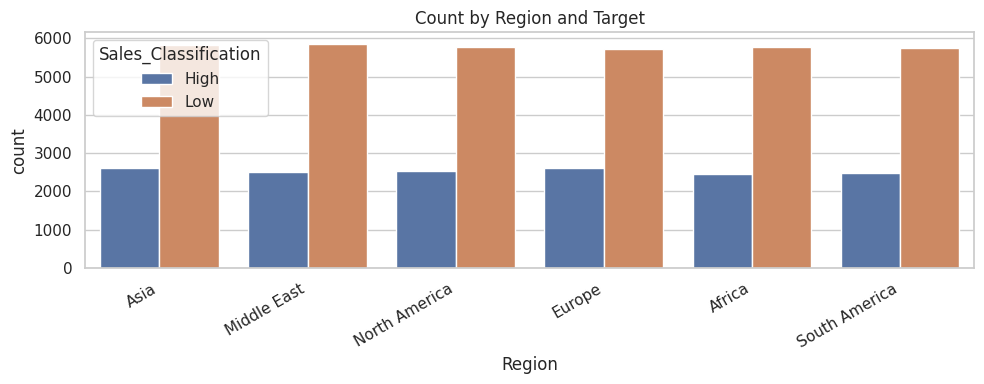

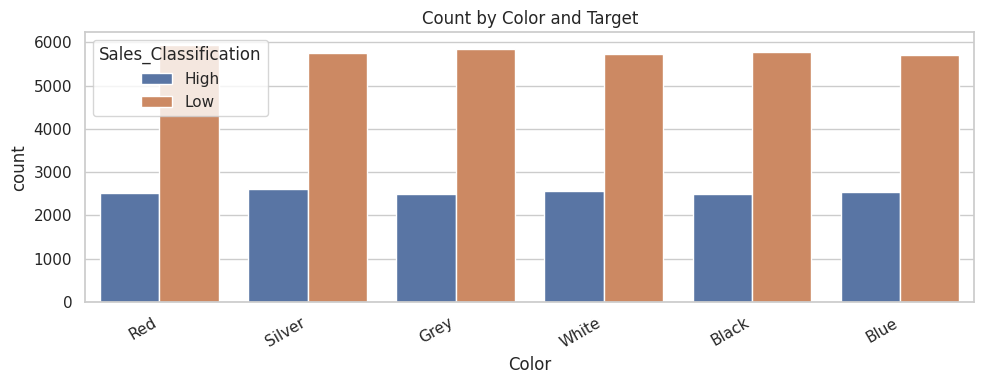

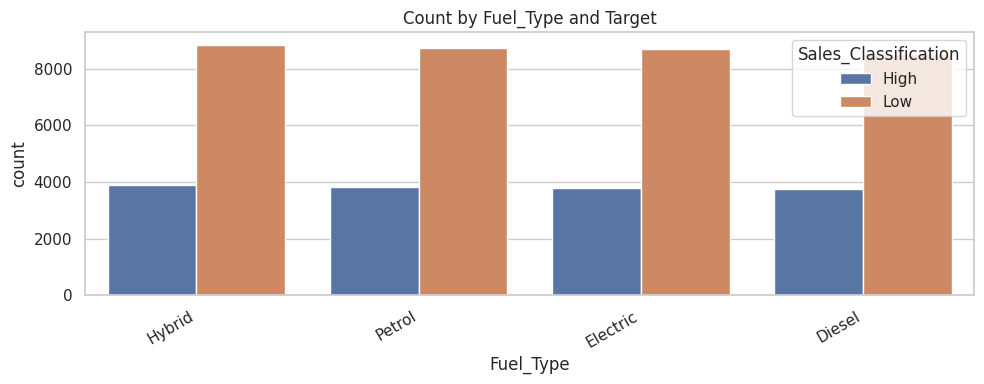

In [6]:
max_cat_plot = 4
for col in categorical_cols[:max_cat_plot]:
    plt.figure(figsize=(10,4))
    order = df[col].astype(str).value_counts().index[:15]
    sns.countplot(data=df, x=col, order=order, hue=TARGET_COL)
    plt.title(f"Count by {col} and Target")
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout(); plt.show()

## Preprocessing and stratified splits
Median-impute and scale numerics; most-frequent impute and one-hot encode categoricals; then do a stratified 70/15/15 split.

In [10]:
# Drop rows with missing target
df = df.dropna(subset=[TARGET_COL]).copy()

# Explicit mapping to {Low:0, High:1} for consistent positive class
y = df[TARGET_COL].astype(str).str.strip().map({'Low': 0, 'High': 1}).values
assert not np.isnan(y).any(), "Unexpected target values; expected only 'High'/'Low'"
X = df.drop(columns=[TARGET_COL])

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='median')),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # Changed sparse to sparse_output
])

preprocess = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=RANDOM_STATE, stratify=y_temp)
print("Train/Val/Test sizes:", len(X_train), len(X_val), len(X_test))

preprocess.fit(X_train)
X_train_t = preprocess.transform(X_train)
X_val_t   = preprocess.transform(X_val)
X_test_t  = preprocess.transform(X_test)
print("Transformed shapes:", X_train_t.shape, X_val_t.shape, X_test_t.shape)

Train/Val/Test sizes: 35000 7500 7500
Transformed shapes: (35000, 34) (7500, 34) (7500, 34)


## Baseline: Logistic Regression (balanced)
Train a strong linear baseline with class_weight='balanced' and benchmark against the deep model.

Baseline Logistic Regression results:
Train  Acc: 0.9938  Prec: 0.9802  Rec: 1.0000  F1: 0.9900  ROC-AUC: 1.0000
              precision    recall  f1-score   support

           0     1.0000    0.9911    0.9955     24328
           1     0.9802    1.0000    0.9900     10672

    accuracy                         0.9938     35000
   macro avg     0.9901    0.9956    0.9928     35000
weighted avg     0.9940    0.9938    0.9938     35000



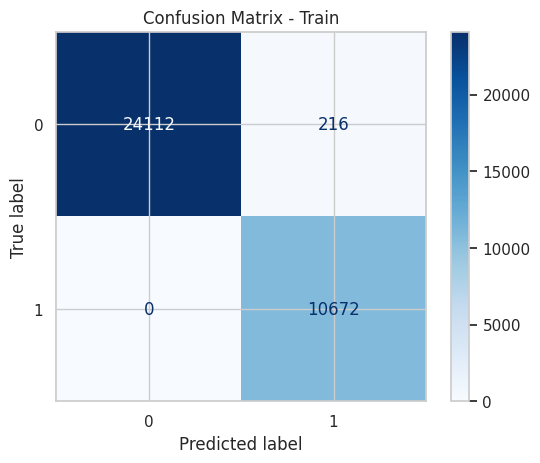

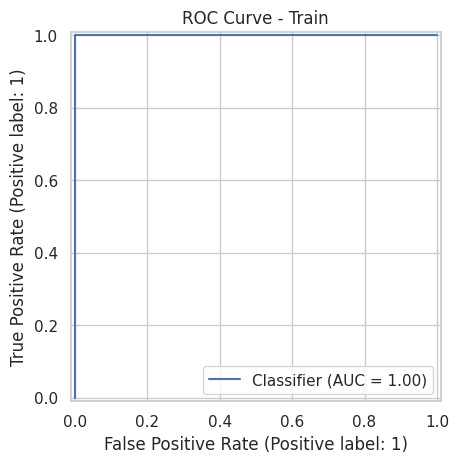

Validation  Acc: 0.9921  Prec: 0.9749  Rec: 1.0000  F1: 0.9873  ROC-AUC: 1.0000
              precision    recall  f1-score   support

           0     1.0000    0.9887    0.9943      5213
           1     0.9749    1.0000    0.9873      2287

    accuracy                         0.9921      7500
   macro avg     0.9874    0.9943    0.9908      7500
weighted avg     0.9923    0.9921    0.9922      7500



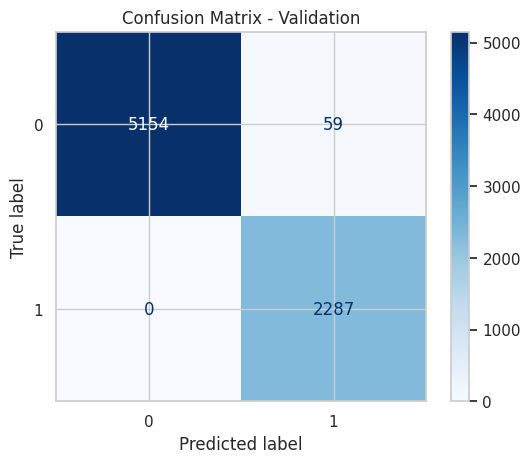

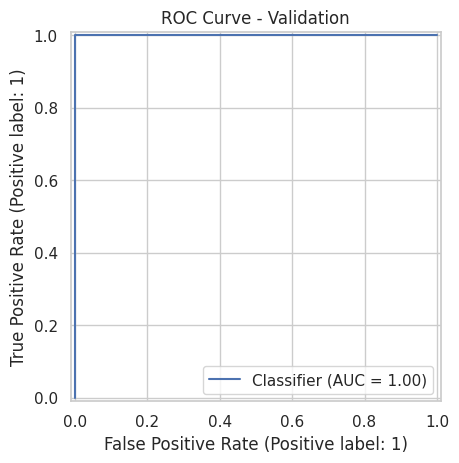

Test  Acc: 0.9925  Prec: 0.9761  Rec: 1.0000  F1: 0.9879  ROC-AUC: 1.0000
              precision    recall  f1-score   support

           0     1.0000    0.9893    0.9946      5213
           1     0.9761    1.0000    0.9879      2287

    accuracy                         0.9925      7500
   macro avg     0.9880    0.9946    0.9913      7500
weighted avg     0.9927    0.9925    0.9926      7500



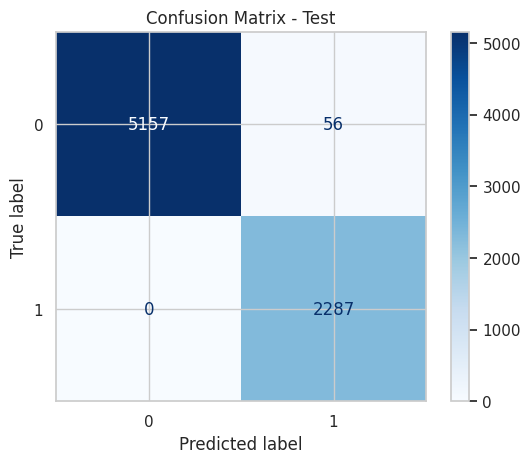

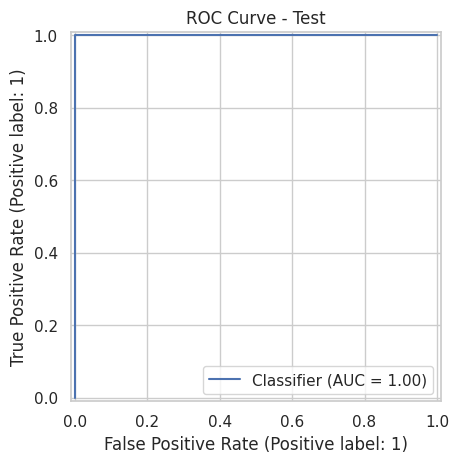

In [11]:
logreg = LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear')
logreg.fit(X_train_t, y_train)

def eval_classifier(clf, X, y, label=""):
    proba = clf.predict_proba(X)[:,1] if hasattr(clf, 'predict_proba') else clf.decision_function(X)
    preds = (proba >= 0.5).astype(int)
    acc = accuracy_score(y, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(y, preds, average='binary', zero_division=0)
    try:
        auc = roc_auc_score(y, proba)
    except Exception:
        auc = np.nan
    print(f"{label}  Acc: {acc:.4f}  Prec: {prec:.4f}  Rec: {rec:.4f}  F1: {f1:.4f}  ROC-AUC: {auc:.4f}")
    print(classification_report(y, preds, digits=4))
    cm = confusion_matrix(y, preds)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {label}")
    plt.show()
    try:
        RocCurveDisplay.from_predictions(y, proba)
        plt.title(f"ROC Curve - {label}")
        plt.show()
    except Exception:
        pass
    return { 'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'auc': auc }

print("Baseline Logistic Regression results:")
baseline_tr = eval_classifier(logreg, X_train_t, y_train, label="Train")
baseline_va = eval_classifier(logreg, X_val_t,   y_val,   label="Validation")
baseline_te = eval_classifier(logreg, X_test_t,  y_test,  label="Test")

## Deep model: PyTorch tabular MLP
A compact MLP with BatchNorm and Dropout is trained using `BCEWithLogitsLoss(pos_weight)` for imbalance, with ReduceLROnPlateau and early stopping.

Using device: cpu
Class counts -> pos: 10672 neg: 24328 pos_weight: 2.2796101570129395
Epoch 01 | train_loss=0.2442 val_loss=0.0887 val_acc=0.9672
Epoch 02 | train_loss=0.1009 val_loss=0.0531 val_acc=0.9830
Epoch 03 | train_loss=0.0916 val_loss=0.0525 val_acc=0.9806
Epoch 04 | train_loss=0.0832 val_loss=0.0495 val_acc=0.9786
Epoch 05 | train_loss=0.0828 val_loss=0.0475 val_acc=0.9829
Epoch 06 | train_loss=0.0848 val_loss=0.0513 val_acc=0.9777
Epoch 07 | train_loss=0.0807 val_loss=0.0507 val_acc=0.9787
Epoch 08 | train_loss=0.0723 val_loss=0.0416 val_acc=0.9846
Epoch 09 | train_loss=0.0773 val_loss=0.0468 val_acc=0.9791
Epoch 10 | train_loss=0.0748 val_loss=0.0414 val_acc=0.9883
Epoch 11 | train_loss=0.0719 val_loss=0.0420 val_acc=0.9839
Epoch 12 | train_loss=0.0698 val_loss=0.0394 val_acc=0.9848
Epoch 13 | train_loss=0.0748 val_loss=0.0425 val_acc=0.9872
Epoch 14 | train_loss=0.0702 val_loss=0.0440 val_acc=0.9801
Epoch 15 | train_loss=0.0699 val_loss=0.0396 val_acc=0.9864
Epoch 16 | tr

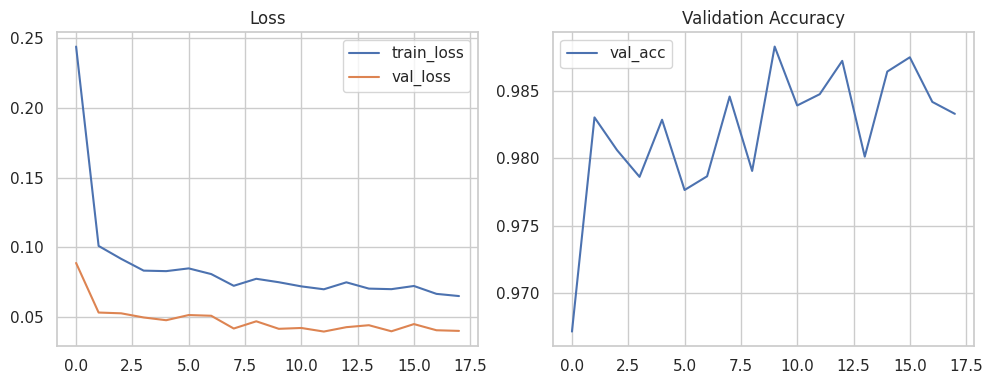

In [12]:
# Prepare tensors
X_train_t = X_train_t.astype(np.float32)
X_val_t   = X_val_t.astype(np.float32)
X_test_t  = X_test_t.astype(np.float32)
y_train_t = y_train.astype(np.float32)
y_val_t   = y_val.astype(np.float32)
y_test_t  = y_test.astype(np.float32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

class NPDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y).view(-1, 1)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_ds = NPDataset(X_train_t, y_train_t)
val_ds   = NPDataset(X_val_t,   y_val_t)
test_ds  = NPDataset(X_test_t,  y_test_t)

# pos_weight for BCEWithLogitsLoss
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
pos_weight = torch.tensor([neg / max(pos, 1)], dtype=torch.float32)
pos_weight = pos_weight.to(device)
print("Class counts -> pos:", int(pos), "neg:", int(neg), "pos_weight:", float(pos_weight))

BATCH_SIZE = 128
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

in_dim = X_train_t.shape[1]
class MLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.25),
            nn.Linear(128, 64),  nn.BatchNorm1d(64),  nn.ReLU(), nn.Dropout(0.25),
            nn.Linear(64, 1)
        )
    def forward(self, x): return self.net(x)

model = MLP(in_dim).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

EPOCHS = 30
best_val_loss, patience, pat_count = float('inf'), 6, 0
history = {"train_loss": [], "val_loss": [], "val_acc": []}

def batch_acc_from_logits(logits, y_true):
    probs = torch.sigmoid(logits).detach().cpu().numpy().ravel()
    preds = (probs >= 0.5).astype(int)
    y = y_true.detach().cpu().numpy().ravel().astype(int)
    return (preds == y).mean()

for epoch in range(1, EPOCHS+1):
    model.train(); train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval(); val_loss = 0.0; val_accs = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item() * xb.size(0)
            val_accs.append(batch_acc_from_logits(logits, yb))
    val_loss /= len(val_loader.dataset)
    val_acc = float(np.mean(val_accs)) if len(val_accs) else 0.0
    history['train_loss'].append(train_loss); history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)
    scheduler.step(val_loss)
    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        pat_count = 0
    else:
        pat_count += 1
        if pat_count >= patience:
            print("Early stopping")
            break

if 'best_state' in locals():
    model.load_state_dict(best_state); model.to(device)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(history['train_loss'], label='train_loss'); plt.plot(history['val_loss'], label='val_loss'); plt.title('Loss'); plt.legend()
plt.subplot(1,2,2); plt.plot(history['val_acc'], label='val_acc'); plt.title('Validation Accuracy'); plt.legend()
plt.tight_layout(); plt.show()

## Evaluation on held-out test set
Report accuracy, precision, recall, F1, ROC–AUC, confusion matrix, and ROC curve to summarize generalization.

MLP Test  Acc: 0.9853  Prec: 0.9545  Rec: 0.9996  F1: 0.9765  ROC-AUC: 0.9998
              precision    recall  f1-score   support

           0     0.9998    0.9791    0.9893      5213
           1     0.9545    0.9996    0.9765      2287

    accuracy                         0.9853      7500
   macro avg     0.9771    0.9893    0.9829      7500
weighted avg     0.9860    0.9853    0.9854      7500



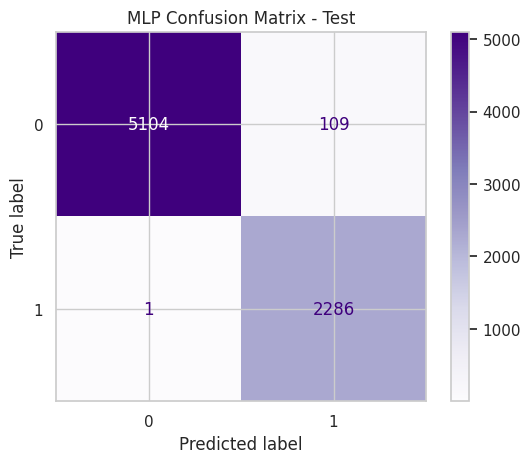

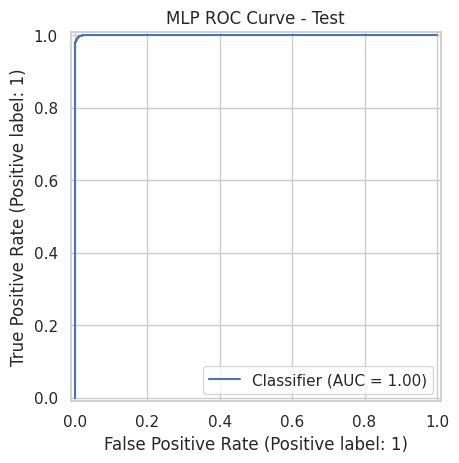

In [13]:
model.eval(); probs_list, preds_list, y_list = [], [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        probs = torch.sigmoid(logits).cpu().numpy().ravel()
        preds = (probs >= 0.5).astype(int)
        probs_list.extend(probs)
        preds_list.extend(preds)
        y_list.extend(yb.numpy().ravel().astype(int))

y_true = np.array(y_list); y_pred = np.array(preds_list); y_prob = np.array(probs_list)
acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
auc = roc_auc_score(y_true, y_prob)
print(f"MLP Test  Acc: {acc:.4f}  Prec: {prec:.4f}  Rec: {rec:.4f}  F1: {f1:.4f}  ROC-AUC: {auc:.4f}")
print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Purples'); plt.title("MLP Confusion Matrix - Test"); plt.show()
RocCurveDisplay.from_predictions(y_true, y_prob); plt.title("MLP ROC Curve - Test"); plt.show()

## Conclusion and next steps
- Summarize key EDA insights connecting features (e.g., Price_USD, Sales_Volume, Engine_Size_L, Region) with class separability.
- Compare baseline vs MLP: note if nonlinearity improved F1/ROC–AUC and whether imbalance handling helped.
- Propose future work: feature engineering, calibration, threshold tuning, and permutation importance on the validation set.